In [1]:
# Draft pour le rendu final 

# Datasets à utiliser: users.csv, beers.csv, reviews.txt.gz 
# (on se focus que sur 1 site pour le moment, à savoir beeradvocate/ratebeer?)

#beers.csv
# print les 5 premières lignes
# d'où viennent les bières par continent 
# 14 catégories faites par le site lui même https://www.beeradvocate.com/beer/styles/ + 1 "weird cocktail"
# combien de bières ont été ratées par nos valid users (après partie filtre rating maybe)

#users.csv
# print les 5 premières lignes
# on regarde le pourcentage des US. Hypothèse: les américains ont accès aux mêmes bières
# discussion autour des valid users -> combien de ratings

# reviews.txt.gz
# d'abord print des exemples de reviews entières (avec le texte etc.)
# Mentionner que le data-set est immense
# Expliquer comment on a loadé les données et les colonnes qu'on a drop pour 
# qu'on puisse gérer le dataset
# Ajoute les ratings, leur temporalité et tous les ratings détaillés (en gros 
# ce que ce que dataset nous apporte)
# Plot de Pale
# Plot de Maxime

# Pour répondre a notre question:
# Métrique de la validité
# Plot de Pale 
# Approche avec les Graphes: on explique la construction pour un user, la construction
# du graphe final, les différentes manières de construire les weights,  
# "Algorithme de Louvain" -> lots of mathematical details (une mesure de clustering)



In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import sys
sys.path.append('/work')
from beer_data_exploration import*

### 

In the datatsets we have there is 3 different datasets : users.csv, beers.csv, reviews.txt.gz for 2 websites. We first focus on beeradvocate website.

First of all, we look the "beers.csv" in more details

In [3]:
#load the data beers.csv
df_beers = pd.read_csv('/datasets/beeradvocate/beers.csv')

In [4]:
df_beers.head(5)


,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN


In [5]:
df_beers.shape

(280823, 15)

We have a total of  280823 beers with 9 variables

For the following, we will consider this variables:

- beer_id

- beer_name : the name of the beer

- brewery id

- Brewery_name : the name of the brewery where the considered beers comes from

- style: this variable  represents the style of the beers

- nbr_reviews and nbr_ratings : the number of ratings and the number of comments respectively for a given beer

- avg : it corresponds to the average ratings for a given beer

In [6]:
list_considered_variable=['beer_id','beer_name','brewery_id','brewery_name','style','nbr_reviews','nbr_ratings','avg']
df_beers=df_beers[list_considered_variable]

In [7]:
df_beers['nbr_ratings'].describe()

count    280823.000000
mean         29.887267
std         231.010063
min           0.000000
25%           1.000000
50%           2.000000
75%           8.000000
max       16509.000000
Name: nbr_ratings, dtype: float64

We observe that 75% of the beers have at most 8 ratings. After this observation, we decided that it might be a good idea to group the beers into categories since we don't want to remove the 75% percent of the beers we have. To do so, we decided to create a variable 'category'. We decided to used the 14 categories for the style made in https://www.beeradvocate.com/beer/styles/.  We also added the category 'Weird cocktail' as this category does not exist anymore.

In [8]:
# we create the new category
df_beers['category'] = df_beers['style'].apply(lambda beer_style: category_check(beer_style))

We want now to investigate how the categories we created are represented

In [9]:
#Create new data frame for the plot 
cat=df_beers.groupby('category').count().beer_id
cat=cat.reset_index()
#normalize to have a percentage per category 
cat.beer_id=cat.beer_id/cat.beer_id.sum()*100
cat['ind']=cat.index
import plotly.express as px
df = px.data.gapminder()

fig = px.scatter(cat, x="ind", y="beer_id",
     size="beer_id", color="category",
                 hover_name="category", size_max=80,labels={"ind": "Category",
                     "beer_id": "Total number of beers per category"})
fig.show()


In this plot above, we can see the  number of beers in each category in percentage. Also, bigger the circle is more there are beers in the category.  We can see that 'Pale Ales' is quite highly represented (almost 25% of the beers are in this category).  The second most represented category is 'Indian Pale Ales'  (represented at almost 18%). For the further analysis, we will have to be  careful about how each category is represented.

In [10]:
#Create new data frame for the plot 
cat=df_beers.groupby('category').count().beer_id
cat=cat.reset_index()
cat = cat.sort_values(by=['beer_id'], ascending=True)
cat=cat.reset_index()
#normalize to have a percentage per category 
cat.beer_id=cat.beer_id/cat.beer_id.sum()*100
cat['ind']=cat.index
import plotly.express as px
df = px.data.gapminder()

fig = px.scatter(cat, x="ind", y="beer_id",
     size="beer_id", color="category",
                 hover_name="category", size_max=80,labels={"ind": "Category",
                     "beer_id": "Total number of beers per category"})
fig.show()

We now focus on the average of the ratings for each category

In [11]:
df_beers.groupby('category').avg.describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Bocks,5037.0,3.706750,0.438740,1.12,3.50,3.76,3.99,5.0
Brown Ales,12362.0,3.709714,0.420009,0.00,3.50,3.75,3.98,5.0
Dark Ales,4879.0,3.693782,0.418825,0.00,3.50,3.75,3.95,5.0
Dark Lagers,5563.0,3.559590,0.488692,0.00,3.32,3.65,3.88,5.0
Hybrid Beers,2739.0,3.629474,0.444672,1.00,3.43,3.68,3.90,5.0
India Pale Ales,45381.0,3.849004,0.389755,0.00,3.65,3.88,4.09,5.0
Pale Ales,58963.0,3.675394,0.425130,0.00,3.48,3.73,3.95,5.0
Pale Lagers,19642.0,3.324800,0.627132,0.00,2.96,3.46,3.77,5.0
Porters,11235.0,3.810827,0.405798,0.00,3.62,3.85,4.05,5.0


[Text(0.5, 1.0, 'Boxplot for avg variable')]

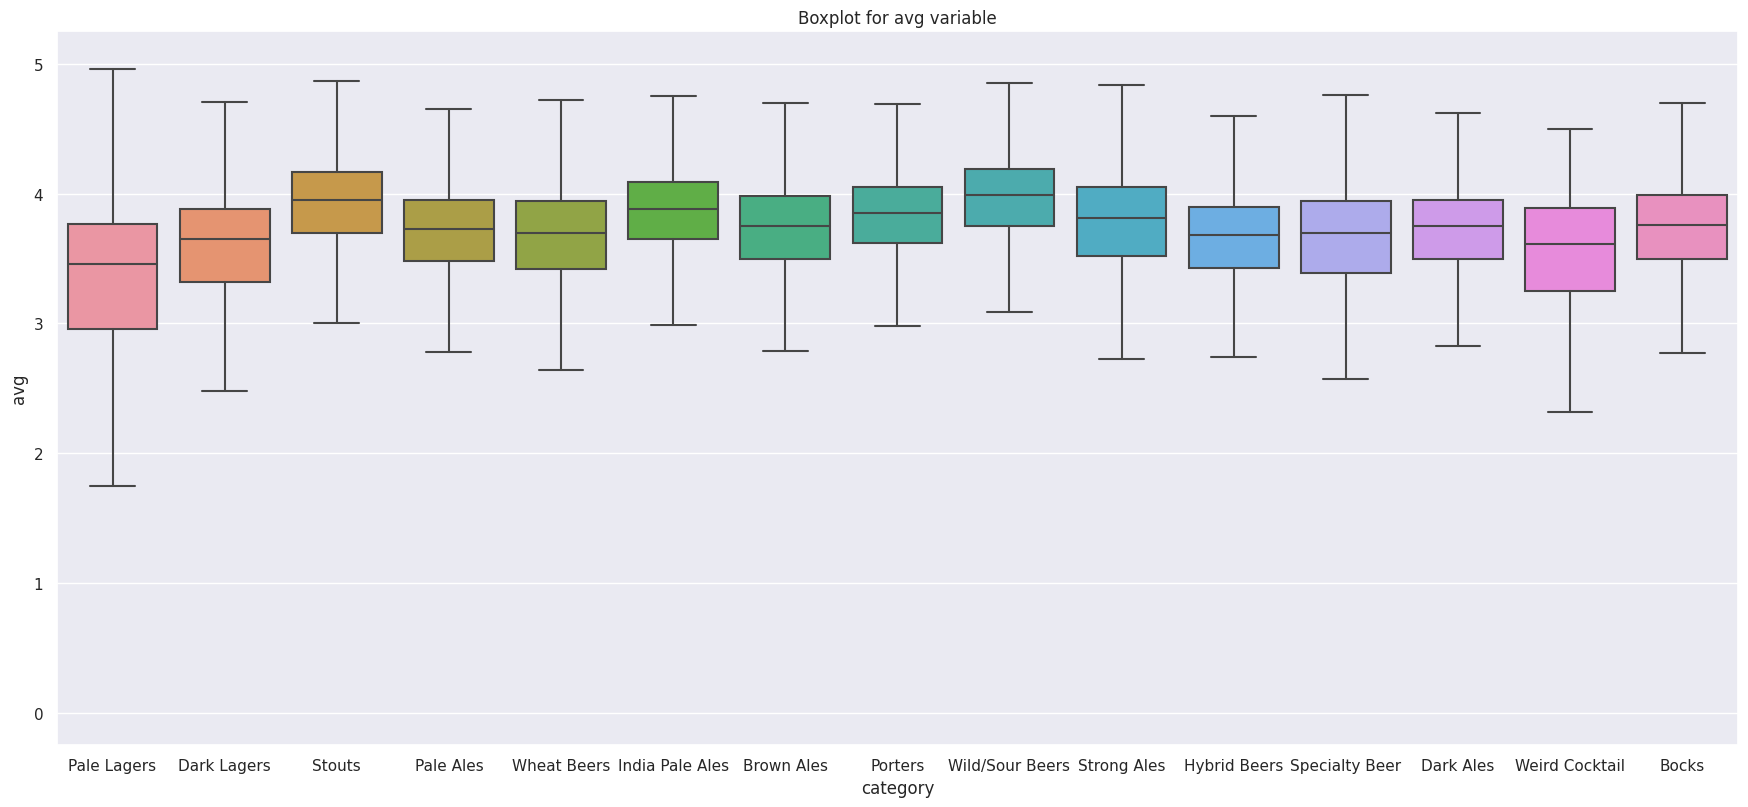

In [12]:
sns.set(rc={'figure.figsize':(21.7,9.27)})
sns.boxplot(data=df_beers, x="category", y="avg",fliersize=0).set(
   title='Boxplot for avg variable')


We can observe that there is not a lot of differences between the average of the ratings for each category. One can observe that the variance for the category 'Pale Lagers' is little higher. It can explained by the large numbers of beers that are contained in this category compared to others categories

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=171b2caa-ea59-44be-b39e-c0d51c875a89' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>